<a href="https://colab.research.google.com/github/mavito/ML_Concepts/blob/main/ML_DensityEstimationWithGMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Density Estimation with Gaussian Mixture Models**

In previous modules, we explored Supervised Learning (Regression and Classification), where our goal was to predict a target label $y$ given an input $x$.

Today, we pivot to Unsupervised Learning. Here, we are given a dataset $X = \{x_1, \dots, x_N\}$ without any labels. Our goal is to uncover the underlying structure of this data.

One of the most powerful ways to describe the structure of data is to estimate the probability distribution that generated it. If we can define a function $p(x)$ (a probability density function) that explains where our data is concentrated, we have essentially learned the "shape" of the data. This is called Density Estimation.

While a simple Histogram or a single Gaussian curve might suffice for simple data, real-world data is often complex, multimodal (having multiple peaks), and irregular. To model this, we use Mixture Models.


Imagine you are looking at a topographic map of a mountain range. A single Gaussian distribution is like a single, perfectly round or oval hill. It has one peak. Now, imagine a landscape with three distinct peaks—a large mountain, a smaller foothill, and a ridge. You cannot describe this entire landscape with a single hill shape.

However, you can describe the landscape by saying, "It is a combination of Hill A (tall, wide), Hill B (short, narrow), and Hill C (medium, elongated)." By stacking these three hills together on the map, you recreate the complex terrain. The GMM does exactly this: it stacks "mathematical hills" (Gaussians) to model the "terrain" of your data.   


----
Real-World Example:

Consider the height of all adults in a city. If you plot the data, you might see two peaks (bimodal)—one centered around the average female height and one around the average male height. A single bell curve would be inaccurate because it would average distinct groups. A Mixture Model combines two bell curves: one for men and one for women, weighted by their population proportions, to perfectly fit the data.

# Visualizing a 1D Mixture

The following code demonstrates how combining two simple Gaussian curves creates a complex, bimodal distribution.

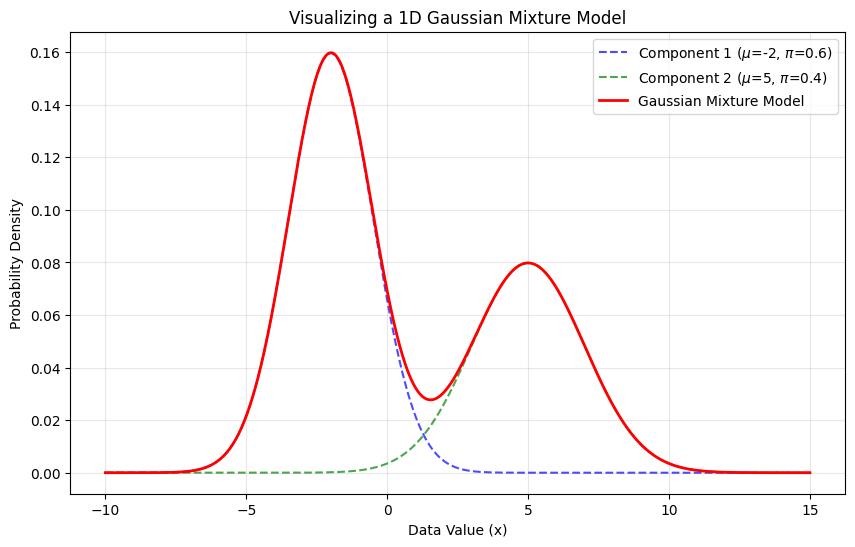

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- SOLUTION CODE ---
def plot_1d_mixture_example():
    # Define the space
    x = np.linspace(-10, 15, 1000)

    # Define Parameters for two components
    # Component 1: Mean = -2, Std Dev = 1.5, Weight = 0.6
    mu1, sigma1, pi1 = -2, 1.5, 0.6
    # Component 2: Mean = 5, Std Dev = 2.0, Weight = 0.4 (weights must sum to 1)
    mu2, sigma2, pi2 = 5, 2.0, 0.4

    # Calculate individual PDFs (Probability Density Functions)
    # norm.pdf takes x, loc (mean), and scale (std dev)
    pdf1 = pi1 * norm.pdf(x, loc=mu1, scale=sigma1)
    pdf2 = pi2 * norm.pdf(x, loc=mu2, scale=sigma2)

    # The Mixture is the sum of the weighted PDFs
    mixture_pdf = pdf1 + pdf2

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot individual components (dashed) to show the "ingredients"
    plt.plot(x, pdf1, '--', label=fr'Component 1 ($\mu$={mu1}, $\pi$={pi1})', color='blue', alpha=0.7)
    plt.plot(x, pdf2, '--', label=fr'Component 2 ($\mu$={mu2}, $\pi$={pi2})', color='green', alpha=0.7)

    # Plot the final mixture (solid) to show the "cake"
    plt.plot(x, mixture_pdf, '-', label='Gaussian Mixture Model', color='red', linewidth=2)

    plt.title('Visualizing a 1D Gaussian Mixture Model')
    plt.xlabel('Data Value (x)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_1d_mixture_example()

## Task 1.1:
Using the code above as a template, create a Python function `visualize_3_component_gmm` that simulates a trimodal distribution (three peaks).


1. Set means at locations -5, 0, and 8.

2. Set standard deviations to 1.0, 0.5, and 1.5 respectively.

3. Set mixing weights to 0.2, 0.5, and 0.3.

4. Plot the three individual components and the combined mixture.

Question: What happens to the shape of the mixture if you increase the standard deviation of the middle component (mean=0) from 0.5 to 3.0? Answer in a comment block.

In [ ]:
#WRITE CODE HERE

## **2. Latent Variable Perspective**
Imagine you have a huge pile of cookies mixed together from two different factories. Factory A produces cookies that are generally larger (mean size 10cm) but with high consistency (low variance). Factory B produces smaller cookies (mean size 6cm) but with lots of variation (high variance). You pick up a specific cookie that is 7cm wide.

You cannot know for sure which factory made it. However, you can calculate the Responsibility. You ask: "How likely is it that Factory A made a 7cm cookie?" and "How likely is it that Factory B made a 7cm cookie?"

If the probability for Factory A is 0.2 and Factory B is 0.8, we say Factory B bears 80% "responsibility" for this cookie. Unlike K-Means clustering, which would force you to say "This IS a Factory B cookie" (Hard Assignment), GMM allows you to say "This is 80% likely to be Factory B" (Soft Assignment).   

**Calculating Responsibilities**

*We will generate a small synthetic dataset and calculate the responsibilities for specific points manually using NumPy.*

In [2]:
import numpy as np
from scipy.stats import norm

# --- SOLUTION CODE ---
def calculate_responsibilities():
    # 1. Data: Let's assume we have 5 data points (1D)
    X = np.array([-2.0, -1.0, 0.0, 3.0, 4.0])

    # 2. Current Estimates of Parameters (Imagine we guessed these)
    # Cluster A: centered at -1.5
    mu_a, sig_a, pi_a = -1.5, 1.0, 0.5
    # Cluster B: centered at 3.5
    mu_b, sig_b, pi_b = 3.5, 1.0, 0.5

    print(f"Data points: {X}")
    print("-" * 30)
    print(f"Cluster A: Mean={mu_a}, Sigma={sig_a}")
    print(f"Cluster B: Mean={mu_b}, Sigma={sig_b}")
    print("-" * 30)

    # 3. Calculate Numerators (Weighted Likelihoods)
    # Likelihood of X belonging to A: pi_a * N(X | mu_a, sig_a)
    likelihood_a = norm.pdf(X, loc=mu_a, scale=sig_a)
    weighted_likelihood_a = pi_a * likelihood_a

    # Likelihood of X belonging to B: pi_b * N(X | mu_b, sig_b)
    likelihood_b = norm.pdf(X, loc=mu_b, scale=sig_b)
    weighted_likelihood_b = pi_b * likelihood_b

    # 4. Calculate Denominator (Total Likelihood per point)
    total_likelihood = weighted_likelihood_a + weighted_likelihood_b

    # 5. Calculate Responsibilities (Gamma)
    # Shape: (N, K) -> Here (5, 2)
    gamma_a = weighted_likelihood_a / total_likelihood
    gamma_b = weighted_likelihood_b / total_likelihood

    # Output results
    print(f"{'Data Point':<12} | {'Resp A (Gamma_a)':<20} | {'Resp B (Gamma_b)':<20}")
    print("-" * 60)
    for i in range(len(X)):
        print(f"{X[i]:<12} | {gamma_a[i]:<20.4f} | {gamma_b[i]:<20.4f}")

calculate_responsibilities()

Data points: [-2. -1.  0.  3.  4.]
------------------------------
Cluster A: Mean=-1.5, Sigma=1.0
Cluster B: Mean=3.5, Sigma=1.0
------------------------------
Data Point   | Resp A (Gamma_a)     | Resp B (Gamma_b)    
------------------------------------------------------------
-2.0         | 1.0000               | 0.0000              
-1.0         | 1.0000               | 0.0000              
0.0          | 0.9933               | 0.0067              
3.0          | 0.0000               | 1.0000              
4.0          | 0.0000               | 1.0000              


## Task 2.1 :
- Write a function `assign_soft_clusters(X, means, stds, weights)` that takes a dataset X and lists of parameters for $K=3$ clusters.
- Input: X = np.array([[0.5], [1.5], [5.0], [6.0], [6.5]])
- Parameters:
  - Means: [1.0, 6.0, 3.5]
  - Std Devs: [0.5, 0.8, 1.2]
  - Weights: [0.33, 0.33, 0.33]
- Return a matrix of size $(5 \times 3)$ containing the responsibilities.
- Identify which data point has the most "ambiguous" classification (i.e., the responsibilities are most spread out across clusters rather than being close to 1 or 0).

In [ ]:
#WRITE CODE HERE

## **3. The Expectation-Maximization (EM) Algorithm**

Imagine you have a dataset of egg sizes, and you know they come from two breeds of chickens (Breed A and Breed B), but you don't know which egg came from which chicken.

- **Goal:** Find the average egg size for Breed A and Breed B.

- **Problem:** To find the average size of Breed A eggs, you need to separate the Breed A eggs. But to separate the eggs, you need to know the average size to tell them apart.   

The EM Solution:

1. Start with a guess: "I guess Breed A eggs average 50g and Breed B average 70g."

2. E-Step (The Guessing/Labeling): Look at every egg. If an egg is 52g, label it "mostly Breed A". If it's 68g, label it "mostly Breed B". (Calculating Responsibilities).

3. M-Step (The Update): Now, take all the eggs you labeled "mostly Breed A". Calculate their actual average weight. Maybe it turns out to be 51g, not 50g. Update your belief. Do the same for Breed B.   

4. Repeat: Go back to E-Step with your new averages (51g and...). Re-label the eggs. Then re-calculate averages. Eventually, the numbers stop changing. You have solved the problem.

## **4. Implementation of a GMM class using NumPy.**



In [4]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, K, max_iters=100, tol=1e-4):
        self.K = K # Number of components
        self.max_iters = max_iters
        self.tol = tol
        self.params = {}

    def initialize_params(self, X):
        n_samples, n_features = X.shape
        # Initialize means randomly from data points
        indices = np.random.choice(n_samples, self.K, replace=False)
        self.params['mu'] = X[indices]

        # Initialize covariances as identity matrices
        self.params['sigma'] = np.array([np.eye(n_features) for _ in range(self.K)])

        # Initialize weights uniformly
        self.params['pi'] = np.ones(self.K) / self.K

    def e_step(self, X):
        n_samples = X.shape[0]
        # We need to calculate P(x | k) * pi_k for all k
        weighted_probs = np.zeros((n_samples, self.K))

        for k in range(self.K):
            # Use scipy's multivariate_normal for stability
            # likelyhood p(x|k)
            likelihood = multivariate_normal.pdf(X, mean=self.params['mu'][k], cov=self.params['sigma'][k])
            weighted_probs[:, k] = self.params['pi'][k] * likelihood

        # Denominator: Sum across components
        sum_probs = weighted_probs.sum(axis=1, keepdims=True)

        # Avoid division by zero
        sum_probs[sum_probs == 0] = 1e-10

        # Responsibilities
        self.gamma = weighted_probs / sum_probs

        # Return log-likelihood for convergence check
        return np.sum(np.log(sum_probs))

    def m_step(self, X):
        n_samples, n_features = X.shape

        # N_k: Effective counts
        N_k = self.gamma.sum(axis=0)

        for k in range(self.K):
            # 1. Update Means
            # weighted sum of x / N_k
            # Reshape gamma for broadcasting
            gamma_k = self.gamma[:, k].reshape(-1, 1)
            self.params['mu'][k] = np.sum(gamma_k * X, axis=0) / N_k[k]

            # 2. Update Covariances
            # (x - mu) * (x - mu)^T weighted
            diff = X - self.params['mu'][k] # Shape (N, D)
            # We want weighted covariance.
            # A trick is to multiply diff by sqrt(gamma) and do dot product
            # Or explicit loop (slower) or broadcasting

            # Weighted covariance calculation:
            sigma_k = np.dot((gamma_k * diff).T, diff) / N_k[k]

            # Add small epsilon to diagonal to prevent singular matrix (crashing)
            self.params['sigma'][k] = sigma_k + np.eye(n_features) * 1e-6

            # 3. Update Weights
            self.params['pi'][k] = N_k[k] / n_samples

    def fit(self, X):
        self.initialize_params(X)
        log_likelihoods = []

        for i in range(self.max_iters):
            current_log_likelihood = self.e_step(X)
            log_likelihoods.append(current_log_likelihood)

            self.m_step(X)

            # Check convergence
            if i > 0 and abs(current_log_likelihood - log_likelihoods[-2]) < self.tol:
                print(f"Converged at iteration {i}")
                break

        return log_likelihoods

In [13]:
# Generate Synthetic Data (2D Blobs)
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
# Run Model
gmm = GaussianMixtureModel(K=4)
history = gmm.fit(X)
print(f"Final Means:\n{gmm.params['mu']}")
print(f"Final Weights:\n{gmm.params['pi']}")

Converged at iteration 14
Final Means:
[[ 0.93021219  4.36350293]
 [-1.62887448  2.84380783]
 [-1.2779446   7.76355138]
 [ 1.95816836  0.8373014 ]]
Final Weights:
[0.25497446 0.24691775 0.2485271  0.24958069]


In [14]:
import plotly.graph_objects as go
from matplotlib.patches import Ellipse

# --- 1. Compute cluster assignments based on final model ---
from scipy.stats import multivariate_normal

def assign_clusters(X, gmm):
    K = len(gmm.params['pi'])
    probs = np.zeros((X.shape[0], K))
    for k in range(K):
        mu_k = gmm.params['mu'][k]
        sigma_k = gmm.params.get('Sigma', [np.eye(2)]*K)[k]  # fallback to identity if not present
        probs[:, k] = gmm.params['pi'][k] * multivariate_normal.pdf(X, mean=mu_k, cov=sigma_k)
    return np.argmax(probs, axis=1)

y_pred = assign_clusters(X, gmm)

# --- 2. Interactive Plot ---
fig = go.Figure()

# Scatter points colored by cluster
for k in range(gmm.K):
    fig.add_trace(go.Scatter(
        x=X[y_pred==k, 0],
        y=X[y_pred==k, 1],
        mode='markers',
        marker=dict(size=6),
        name=f'Cluster {k+1}'
    ))

# Cluster means
fig.add_trace(go.Scatter(
    x=gmm.params['mu'][:, 0],
    y=gmm.params['mu'][:, 1],
    mode='markers',
    marker=dict(size=12, symbol='x', color='black'),
    name='Cluster Means'
))

# Layout
fig.update_layout(
    title="GMM Clustering Visualization",
    xaxis_title="Feature 1",
    yaxis_title="Feature 2",
    width=800,
    height=600
)

fig.show()

## Task 4

1. Generate Data: Use `make_blobs` to generate a dataset with 4 centers.

2. Visualization: Write a visualization function that plots the data points.

3. Iterative Plotting: Modify the fit loop in the `GaussianMixtureModel` class above. Every 5 iterations, call your visualization function to plot the data points AND the current estimated cluster means.

4. Observation: Run the code. You should see the cluster means (starting randomly) "walk" toward the centers of the data blobs and settle there.

5. Challenge: Initialize the means to be very far away (e.g., +100 away from data).
- Does the algorithm still work?
- If it fails or gets stuck in a "local optimum" (where it splits one blob into two and ignores another), explain why in your notebook.

In [ ]:
#WRITE CODE HERE

## **5. Model Selection (How many clusters?)**

In K-Means and GMM, we must specify $K$ (number of components) beforehand. If $K$ is too low, we underfit (merge distinct groups). If $K$ is too high, we overfit (model noise as clusters).Since MLE always increases as we add more parameters (clusters), we cannot simply pick the $K$ with the highest likelihood. We use Information Criteria that penalize complexity:
- BIC (Bayesian Information Criterion): $BIC = \ln(N)k - 2\ln(\hat{L})$
- AIC (Akaike Information Criterion): $AIC = 2k - 2\ln(\hat{L})$
Where $k$ is the number of parameters, $N$ is the number of data points, and $\hat{L}$ is the likelihood. We want to minimize these values.

## Task 5

Using the built-in sklearn.mixture.GaussianMixture (to save time):
1. Generate a dataset with 5 clusters.
2. Loop through $K = 1$ to $10$.
3. For each $K$, fit the model and store the bic() value (built-in method).
4. Plot $K$ vs BIC.
5. Identify the "elbow" or the minimum point. Does it correctly identify $K=5$?